### Task description
A/A testing of a mobile application. It is necessary to calculate the results of the A / A test by checking the FPR quality metric (we will check for conversions to a purchase). The split system is known to be broken. It is required to check the statement about the breakdown and find its causes if the split system is really broken  

#### Description of columns  
experimentVariant – variant of the experiment  
version – application version  
purchase – fact of purchase  

#### Task  
Run an A/A test 
Calculate FPR at alpha level = 0.05  
Find the causes of the breakdown of the split system, focusing on the results of the experiment (hint: find an anomaly in the application version) 
Write conclusions that can be drawn from the analysis of the results of the A / A test 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df_mobile = pd.read_csv('C:/Users/HP/Downloads/hw_aa.csv', sep = ';')

In [3]:
df_mobile.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
df_mobile.groupby('experimentVariant').agg({'purchase': 'mean'})

,purchase
experimentVariant,
0,0.023945
1,0.053242


In [5]:
df_mobile.groupby(['experimentVariant', 'version'], as_index = False).agg({'purchase': 'mean', 'uid': 'count'}) \
        .rename(columns = {'purchase': 'conversion'})

,experimentVariant,version,conversion,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


#### Как видно из получившейся таблицы, несмотря на то, что сплит по количеству был произведен корректно, процентное соотношение в версии 'v2.8.0' неверное.  
#### Это может говорить об ошибке. Для подтверждения нашей гипотезы проведем А/А тесты по всем версиям в отдельности.

In [6]:
for j in ['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0']:
    n = 100000
    simulations = 1000
    n_s = 1000
    res = []

    df_1 = df_mobile.query('version == "{}" & experimentVariant == 0'.format(j)).purchase
    df_2 = df_mobile.query('version == "{}" & experimentVariant == 1'.format(j)).purchase

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = df_1.sample(n_s, replace = False).values
        s2 = df_2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    p_value = sum(np.array(res) <0.05) / simulations
    print("p_value of version {} = {}".format(j, p_value))


p_value of version v2.8.0 = 1.0



p_value of version v2.9.0 = 0.049



p_value of version v3.7.4.0 = 0.03



p_value of version v3.8.0.0 = 0.055


### В связи с получившимися результатами, исключим первую версию, и проверим А/А тест эксперементальных групп без нее

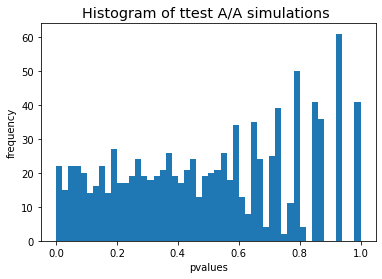

0.041

In [7]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df_1 = df_mobile.query('(version == "v3.7.4.0" | version == "v3.8.0.0" | version == "v2.9.0") & experimentVariant == 1').purchase
df_2 = df_mobile.query('(version == "v3.7.4.0" | version == "v3.8.0.0" | version == "v2.9.0") & experimentVariant == 0').purchase
for i in tqdm(range(simulations)):
    s1 = df_1.sample(n_s, replace = False).values
    s2 = df_2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
sum(np.array(res) <0.05) / simulations

### Сравним с результатами, которые можно получить, если не исключать ни одну из версий

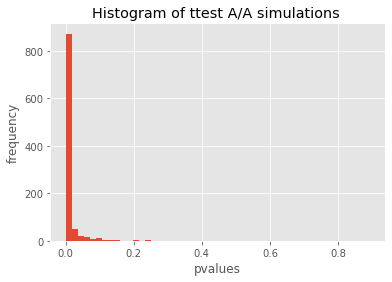

0.936

In [8]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df_1 = df_mobile.query('experimentVariant == 1').purchase
df_2 = df_mobile.query('experimentVariant == 0').purchase
for i in tqdm(range(simulations)):
    s1 = df_1.sample(n_s, replace = False).values
    s2 = df_2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
sum(np.array(res) <0.05) / simulations

#### Таким образом можно предположить, что проблемма именно в версии v2.8.0. Обратим внимание, что p_value версий v2.9.0  и  v3.8.0.0 при повторном тестировании иногда переходят порог 0,05 в большую сторону. Поэтому имея при себе больше данных, возможно, можно было бы сказать что-то большее.